# US BANK WAGES - EXPLORATORY DATA ANALYSIS

<img src="https://i.imgur.com/C5MdknY.jpg" alt="New York Wall Street 1918 (colorized)" width="300" class="center"/>

In this notebook an Exploratory Data Analysis is performed on employee data from an US bank. The goal is to predict an employee's salary as accurately as possible from three different perspectives - applicant, employer, researcher. During analysis selected insights are highlighted. Analysis is performed according to the following structure:

1. Preparation
    - Import Modules
    - Settings
    - Import Data
2. Univariate Analysis
    - Overview
    - Target Variable
    - Feature Engineering
    - Inequality
3. Bivariate Analysis
    - Heatmap
    - Overview by Gender
    - Inequality by Gender
4. Multivariate Analysis
    - Overview
    - OLS Regressions
        - Model 1 - Applicant
        - Model 2 - Employer
        - Model 3 - Gender Inequality
5. Summary

# Preparation

## Import modules

In [286]:
# Import packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse

## Settings

In [287]:
# Set pandas number format to two decimals
pd.set_option('float_format', '{:.2f}'.format)

## Import data

In [288]:
# Read in data
df = pd.read_csv('us_bank_wages.txt', delimiter = "\t")
# Show first lines of data 
df.head()

,Unnamed: 0,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
0,0,57000,15,27000,1,0,3
1,1,40200,16,18750,1,0,1
2,2,21450,12,12000,0,0,1
3,3,21900,8,13200,0,0,1
4,4,45000,15,21000,1,0,1


In the table above we can see that the dataset was imported correctly. The first column "Unnamed:0" seems to stem from an index in the raw data and is redundant since our dataframe holds the same indexes after import. All variables seem to be stored in numeric format.   

In [290]:
# Delete duplicated index column
df = df.drop('Unnamed: 0', axis=1)

In [289]:
# List variables' data types
df.dtypes

Unnamed: 0    int64
SALARY        int64
EDUC          int64
SALBEGIN      int64
GENDER        int64
MINORITY      int64
JOBCAT        int64
dtype: object

After dropping the redundant "Unnamed: 0" column we learn that all remaining variables are stored as integers in our dataframe. This will come in handy later when we look at associations between variables. While measuring "SALARY", "EDUC", "SALBEGIN" in numbers is intuitive, measuring "GENDER", "MINORITY", "JOBCAT" in numbers seems weird. We can think of those later ones as coded values, i.e. assignment of an numeric value for each distinct qualitative category. [Here is an overview](column_names.md) of what kind of information each variable holds.


In [326]:
df.shape

(474, 6)

In [291]:
# Check for missing values
df[df.isnull().any(axis=1)]

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT


Next, we check for missing values in our dataset. Luckily, we have all variables filled with valid values for each observation. Thus, there is no need to handle missing data.

# Univariate Analysis

## Overview

In [358]:
df.describe()

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
count,474.00,474.00,474.00,474.00,474.00,474.00
mean,34419.57,13.49,17016.09,0.54,0.22,1.41
std,17075.66,2.88,7870.64,0.50,0.41,0.77
min,15750.00,8.00,9000.00,0.00,0.00,1.00
25%,24000.00,12.00,12487.50,0.00,0.00,1.00
50%,28875.00,12.00,15000.00,1.00,0.00,1.00
75%,36937.50,15.00,17490.00,1.00,0.00,1.00
max,135000.00,21.00,79980.00,1.00,1.00,3.00


Looking at the table above gives us a good first impression of the content and distribution of our variables. As mentioned earlier there are no missing values and we have a constant sample size of n = 474 for all variables. Find a selection of more specific findings below:

- SALARY
    - Arithmetic mean at 34k with stddev of 17k
    - Range from ~16k to 135k
    - Mean > Median -> right skewed
- EDUC
    - Arithmetic mean at ~13 years with stddev of ~3 years
    - Range from 8 years to 21 years
    - Mean > Median -> right skewed
- SALBEGIN
    - Arithmetic mean at 17k with stddev of ~8k
    - Range from 9k to ~80k
    - Mean > Median -> right skewed
- GENDER
    - 54% of employees are male
- MINORITY
    - 22% of employees belong to ethnic minority
- JOBCAT
    - Majority of employees work in adminstrative jobs


It is evident that the target variable is not uniformly distributed, i.e. not all employees get the same salary. Our task is to explain this difference in earnings using the information from the remaining variables. Thus, we will start having a closer look at our dependent variable before we see how to generate more information from our variables.

## Target Variable

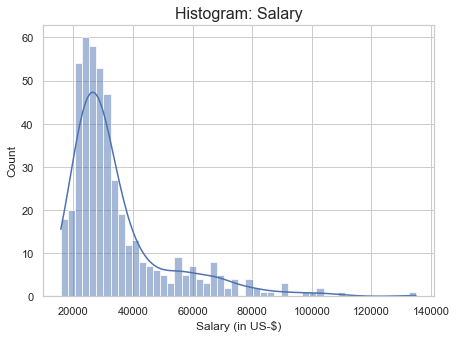

In [558]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
sns.histplot(data=df, x="SALARY", bins=50, kde=True)
plt.xlabel("Salary (in US-$)")
plt.title("Histogram: Salary")
plt.show(fig);

Looking at the histogram of the "SALARY" variable we find the expected right skewed distribution, i.e. a distribution with a long tail on the right hand side. One way to handle this skewedness would be to remove outliers from the dataset. While this would most definitely solve the problem of skewedness it would make our predictions more prone to errors when predicting high salaries. Alternativley, we can log-transform the distribution in order to "draw in" large values and potentially normalize the distribution overall. [Check this blog post](https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution) for favorable properties of log-transformed variables.

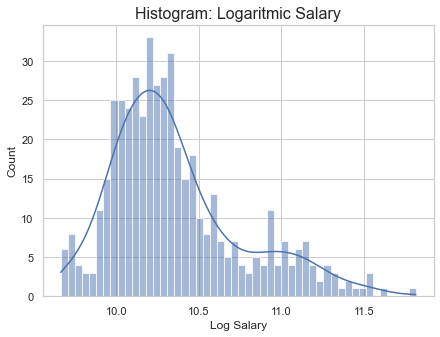

In [557]:
df_log = pd.DataFrame(np.log(df['SALARY']))
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
sns.histplot(data=df_log, x="SALARY", bins=50, kde=True)
plt.xlabel("Log Salary")
plt.title("Histogram: Logaritmic Salary") # You can comment this line out if you don't need title
plt.show(fig);

Looking at the transformed distribution of the "SALARY" variable we see that the bars moved closer together and also that the left hand side of the graph now resembles a normal distribution. 

## Feature Engineering

In [13]:
# Check for emloyees with original salary
df_fj = pd.DataFrame(df.query('SALARY == SALBEGIN'))
df_fj.head()

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT


One information that is missing from the dataset is employees' tenure. When we look for employees who still earn their starting salary, we get back the empty table displayed above. Thus, all employees included in the data se seem to have worked for this bank for a while already. 

In [328]:
df_diff = df.copy()
df_diff['SALINCREASE_ABS'] = df_diff.eval('SALARY - SALBEGIN')
df_diff['SALINCREASE_REL'] = df_diff.eval('SALINCREASE_ABS / SALBEGIN')
df_diff = df_diff.drop('SALINCREASE_ABS', axis=1)
pd.DataFrame(df_diff['SALINCREASE_REL']).describe()

,SALINCREASE_REL
count,474.00
mean,1.02
std,0.40
min,0.25
25%,0.75
50%,0.96
75%,1.22
max,4.08


From the given data we may calculate how much each employee's salary increased from their starting salary. In order to do this we substract the starting salary from the current salary and then discount this difference by starting salary. The result tells us how much an employee's salary increased relative to their starting salary. The mean for this variable is ~1 and therefore the average employee approximately doubled their salary since starting to work for the bank.

**Please note:** The variable "SALINCREASE_REL" as calculated above contains the (relative) difference between "SALBEGIN" and "SALARY". Using this variable (together with SALBEGIN) in regression models for prediction is wrong from a methodological perspective because it basically contains all the missing information a regression model would try to infer. Also, from the calculation logic we know that using this variable renders out-of-sample predictions impossible (i.e. when we try to predict "SALRAY" or "SALBEGIN" we do not have the differnce available).  

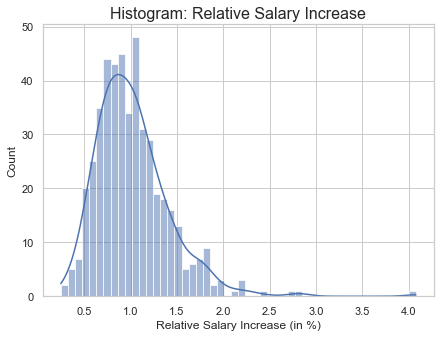

In [559]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
sns.histplot(data=df_diff, x="SALINCREASE_REL", bins=50, kde=True)
plt.xlabel("Relative Salary Increase (in %)")
plt.title("Histogram: Relative Salary Increase") # You can comment this line out if you don't need title
plt.show(fig);

At a first glance the shape of the relative salary increase looks similar to what we found for the current salary - right skewed with the left hand side resembeling a normnal distribution. But wait, this would mean not only that the income itself is unevenly distributed among employees but that this inequality is amplified over time? Let's have a look if this hypothesis holds.

## Inequality

In [333]:
# Function to calculate Gini-coefficient
def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

Defined above is a function to calculate the Gini-coefficient ([Source: Stackoverflow](https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy)). The Gini-coefficient is often used in social sciences to quantify inequality. Its values range from 0 to 1 where 0 is perfect equality and 1 is perfect inequality ([Wikipedia](https://en.wikipedia.org/wiki/Gini_coefficient)).

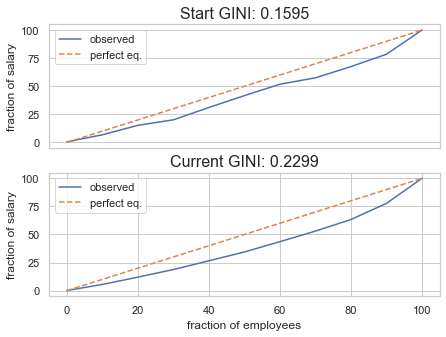

In [560]:
bins_s, result_s, gini_val_s = G(df_diff['SALBEGIN'])
bins_c, result_c, gini_val_c = G(df_diff['SALARY'])

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(bins_s, result_s, label="observed")
plt.plot(bins_s, bins_s, '--', label="perfect eq.")
plt.xticks([])
plt.ylabel("fraction of salary")
plt.title("Start GINI: %.4f" %(gini_val_s))
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(bins_c, result_c, label="observed")
plt.plot(bins_c, bins_c, '--', label="perfect eq.")
plt.xlabel("fraction of employees")
plt.ylabel("fraction of salary")
plt.title("Current GINI: %.4f" %(gini_val_c))
plt.legend();

Indeed, we find that the GINI-coefficient increased between the starting and current salary. Moving forward we will dive a little deeper into how part of this inequality might be shaped.

# Bivariate Analysis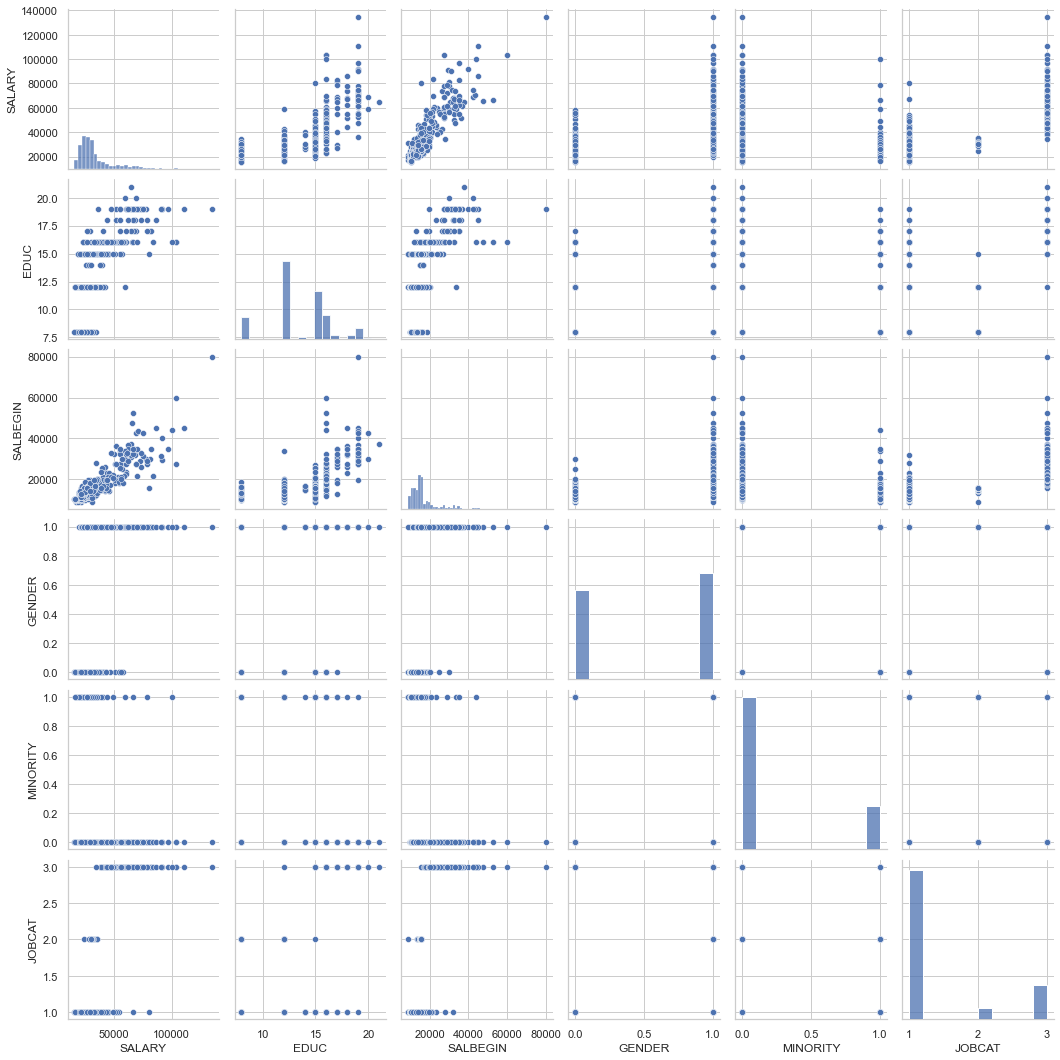

## Heatmap

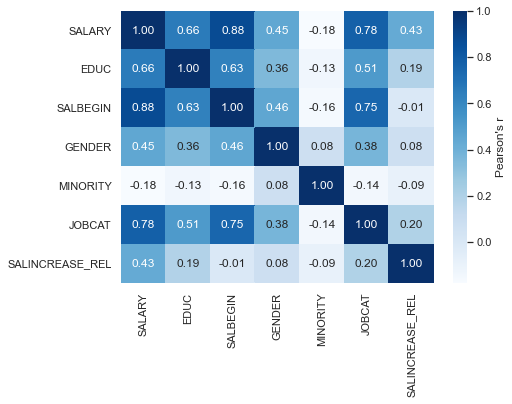

In [561]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":12,"axes.titlesize":16,"axes.labelsize":12})
heat_map = sns.heatmap(df_diff.corr(), cmap='Blues', 
                       annot=True, fmt='.2f' ,
                       cbar_kws={'label': "Pearson's r",
                                 'orientation': 'vertical'})
heat_map.set_xticklabels(heat_map.get_xticklabels(),
                         rotation=90);

The heatmap above shows the associations between all data in our dataset using the correlation coefficient Pearson's r. While Pearson's r measures the linear relationship between metric variables well, it is less suited to show the association between metric and categorical variables or categorical and categorical variables. For the sake of overview in the heatmap above all variables are displayed. 

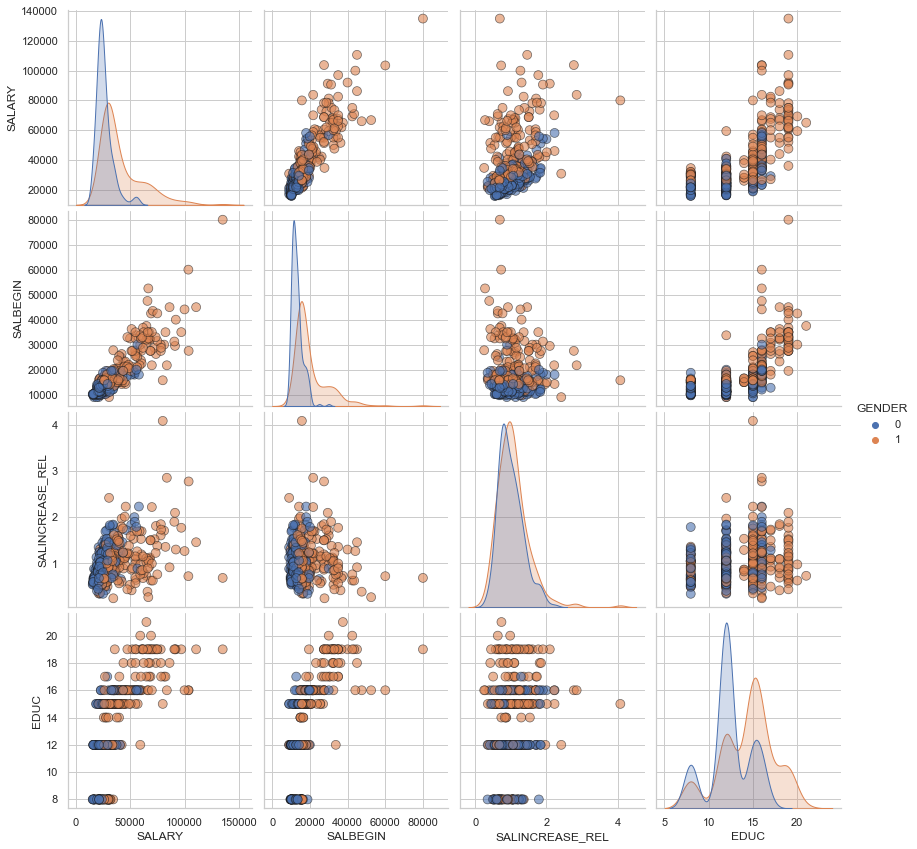

In [566]:
sns.pairplot(df_diff, vars=["SALARY", "SALBEGIN", 
                            "SALINCREASE_REL", "EDUC"], 
             hue='GENDER', diag_kind="kde", 
             plot_kws = {'alpha': 0.6, 
                         's': 80, 'edgecolor': 'k'},
             height = 3);

## Overview by Gender

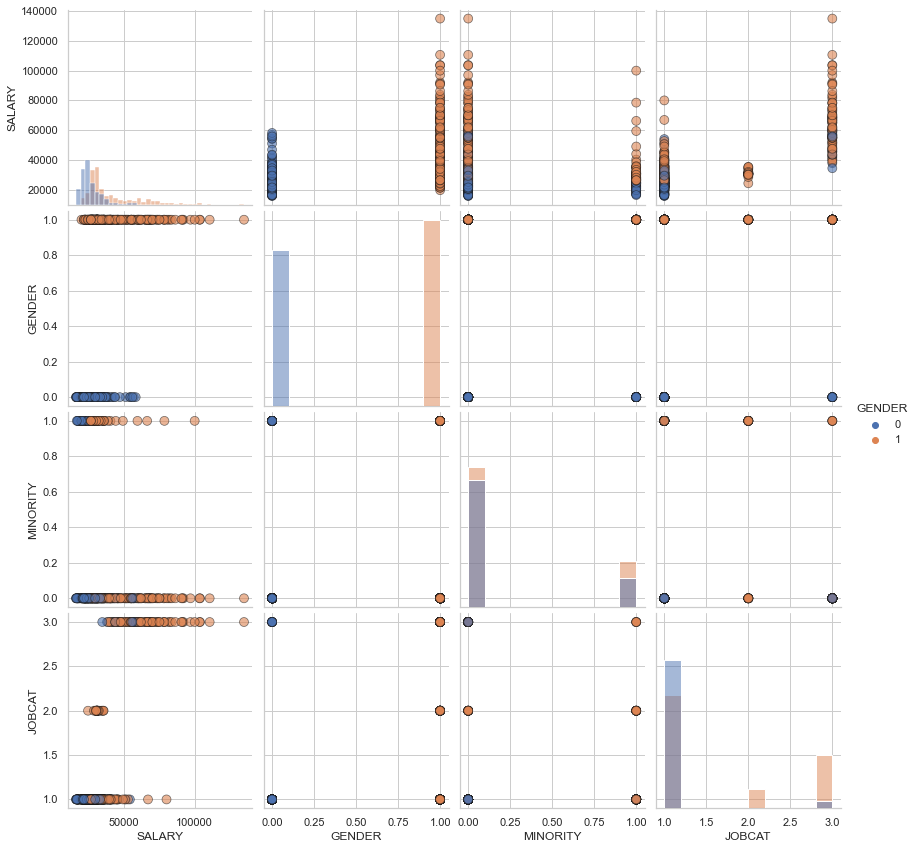

In [373]:
sns.pairplot(df_diff, vars=["SALARY", "GENDER",
                            "MINORITY", "JOBCAT"], 
             hue='GENDER', diag_kind="hist", 
             plot_kws = {'alpha': 0.6, 
                         's': 80, 'edgecolor': 'k'},
             height = 3);

Inspecting the bivariate associations visually there pop up some aspects to highlight:
- Salary has a positive linear relation with starting salary
- Salary has a positive linear association with relative salary increase
- Salary has a rather exponential relation with education (return of investment increases with duration of education)
- Women cluster at or near the lower end of each bivariate association
- Women on average fare worse than their male counterparts in all distributions

## Inequality by Gender

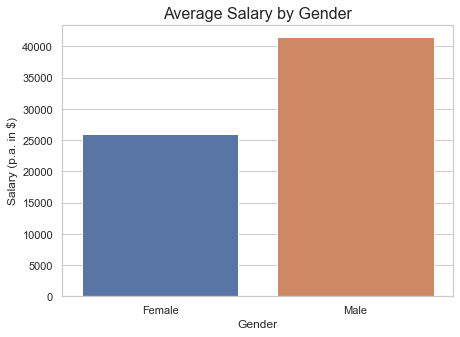

In [549]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":8,"axes.titlesize":16,"axes.labelsize":12})
ax = sns.barplot(data=df_sex, x='SEX', y="SALARY")
sns.barplot(data=df_sex, x='SEX', y="SALARY").set(title='Average Salary by Gender') #set the plot title
ax.set(xlabel='Gender', ylabel='Salary (p.a. in $)')
plt.show();

Looking at the barchart above makes the last point pretty clear: On average women working for the bank earn substantially less than men.

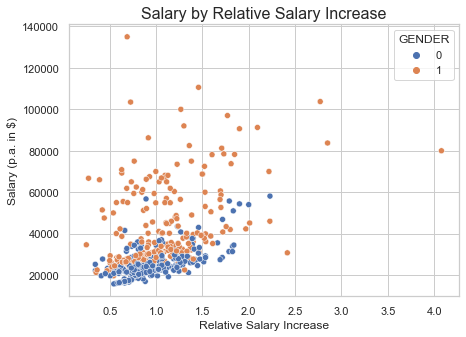

In [575]:
sns.set_theme(style="whitegrid", font_scale=1 ,rc={'figure.figsize':(7,5),"font.size":8,"axes.titlesize":16,"axes.labelsize":12})
ax = sns.scatterplot(x="SALINCREASE_REL", y="SALARY", hue="GENDER", data=df_diff)
ax.set(title='Salary by Relative Salary Increase', xlabel='Relative Salary Increase', ylabel='Salary (p.a. in $)')
plt.show();

The scatterplot above charting the current salary with the relative salary increase gives a hint that this inequality may be amplified over time to the disadvantage of women.

# Multivariate

## Overview

Before interpreting the results from our regression models in detail we first have a high-level look at the explanatory power of our features and the multivariate dependencies in our data. In order to do so we have a look at the following tables:
- R_squared by feature in bivariate regression on salary
- Adjusted_R_squared by regression equations in stepwise regression on salary
- Adjusted_R_squared by regression equations each omitting one feature in regression on salary

In [548]:
X = df_diff.drop(['SALARY', 'SALINCREASE_REL'], axis=1)
result = {}
for cols in X.columns:
    result[cols] = smf.ols(formula='SALARY ~ ' + str(cols), data=df).fit().rsquared
    
df_result = pd.DataFrame(result, index=['R_squared']).transpose()    
df_result

,R_squared
EDUC,0.44
SALBEGIN,0.77
GENDER,0.20
MINORITY,0.03
JOBCAT,0.61


In [415]:
#X = df_diff.drop(['SALARY', 'SALINCREASE_REL'], axis=1)
result = {}
reg_eq = 'SALARY ~ '
for i, cols in enumerate(X.columns):
    if i > 0:
        reg_eq += " + " + str(cols)
        result[reg_eq] = smf.ols(formula=reg_eq, data=df).fit().rsquared_adj
    else:
        reg_eq += str(cols)
        result[reg_eq] = smf.ols(formula=reg_eq, data=df).fit().rsquared_adj
        
df_result = pd.DataFrame(result, index=['adj_R_squared']).transpose()    
df_result

,adj_R_squared
SALARY ~ EDUC,0.44
SALARY ~ EDUC + SALBEGIN,0.79
SALARY ~ EDUC + SALBEGIN + GENDER,0.79
SALARY ~ EDUC + SALBEGIN + GENDER + MINORITY,0.79
SALARY ~ EDUC + SALBEGIN + GENDER + MINORITY + JOBCAT,0.82


In [414]:
#X = df_diff.drop(['SALARY', 'SALINCREASE_REL'], axis=1)
result = {}
reg_eq = ['SALARY ~ ']*len(X.columns)
for j, cols in enumerate(X.columns):
    for i, cols2 in enumerate(X.columns):
        if cols2 != cols and i < 1:
            reg_eq[j] += str(cols2)
        elif cols2 != cols:
            reg_eq[j] += " + " + str(cols2)
    result[reg_eq[j]] = smf.ols(formula=reg_eq[j], data=df).fit().rsquared_adj
    
df_result = pd.DataFrame(result, index=['adj_R_squared']).transpose()    
df_result

,adj_R_squared
SALARY ~ + SALBEGIN + GENDER + MINORITY + JOBCAT,0.81
SALARY ~ EDUC + GENDER + MINORITY + JOBCAT,0.71
SALARY ~ EDUC + SALBEGIN + MINORITY + JOBCAT,0.82
SALARY ~ EDUC + SALBEGIN + GENDER + JOBCAT,0.82
SALARY ~ EDUC + SALBEGIN + GENDER + MINORITY,0.79


Knowing what we already know from our bivariate analysis we do not find any real surprises in the multivariate analyses. Here are some observations:
- SALBEGIN is the strongest predictor for salary (bivariate and omitted)
- The highest score on adjusted R_squared is achieved by including all variables into the model
- Omitting GENDER or MINORITY from the model seems to have the smallest penalty for the adjusted R_squared value

## Model 1 - Applicant

In [543]:
X_1 = df_diff[['EDUC', 'GENDER', 'MINORITY', 'JOBCAT']]
y_1 = df_diff['SALBEGIN']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.33, random_state=42, shuffle=True)

# Merge datasets after test split for formula notation
X_train_1 = X_train_1.merge(y_train_1, left_index = True, right_index=True)

# Create and train an OLS model
results_1 = smf.ols(formula='np.log(SALBEGIN) ~ EDUC + C(GENDER) + C(MINORITY) + C(JOBCAT)', data=X_train_1).fit()

# Return output of the model
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(SALBEGIN)   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     225.5
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          3.77e-101
Time:                        09:26:21   Log-Likelihood:                 120.25
No. Observations:                 317   AIC:                            -228.5
Df Residuals:                     311   BIC:                            -206.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.0034      0.055    163.921      0.000       8.895       9.111
C(GENDER)[T.1]       0.2062      0.022      9.300      0.000       0.163       0.250
C(MINORITY)[T.1]    -0.0484      0.024     -2.043      0.042      -0.095      -0.002
C(JOBCAT)[T.2]       0.0756      0.045      1.663      0.097      -0.014       0.165
C(JOBCAT)[T.3]       0.4551      0.031     14.845      0.000       0.395       0.515
EDUC                 0.0358      0.004      8.211      0.000       0.027       0.044
==============================================================================
Omnibus:                       99.498   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.383
Skew:                           1.349   Prob(JB):                     1.00e-75
Kurtosis:                       7.343   Cond. No.                         90.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our first model predicts the starting salary (SALBEGIN) as a linear function of education (EDUC), gender (GENDER), minority status (MINORITY), and job category (JOBCAT). 
This model could be used by an applicant who wants to evaluate their starting salary before starting negotiations. 
According to the regression results there is no statistical significant difference in expected starting salary between administration and custodial jobs (p>0.05).

In [541]:
y_prediction_1 = results_1.predict(X_test_1)
y_prediction_1 = np.exp(y_prediction_1)
rmse_model_1 = rmse(y_test_1.astype(np.int64), y_prediction_1.astype(np.int64))
rmse_model_1

3810.582089375928

Testing the model on the test data reveals that our model has a root mean squared error (RMSE) of ~3811.

## Model 2 - Employer

In [542]:
X_2 = df_diff[['EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']]
y_2 = df_diff['SALARY']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.33, random_state=42, shuffle=True)

# Merge datasets after test split for formula notation
X_train_2 = X_train_2.merge(y_train_2, left_index = True, right_index=True)

# Create and train an OLS model
results_2 = smf.ols(formula='np.log(SALARY) ~ EDUC + np.log(SALBEGIN) + C(GENDER) + C(MINORITY) + C(JOBCAT)', data=X_train_2).fit()

# Return output of the model
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(SALARY)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     268.7
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          1.30e-119
Time:                        09:15:50   Log-Likelihood:                 121.89
No. Observations:                 317   AIC:                            -229.8
Df Residuals:                     310   BIC:                            -203.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.6080      0.512      7.051      0.000       2.601       4.615
C(GENDER)[T.1]       0.0427      0.025      1.709      0.089      -0.006       0.092
C(MINORITY)[T.1]    -0.0426      0.024     -1.795      0.074      -0.089       0.004
C(JOBCAT)[T.2]       0.1239      0.045      2.724      0.007       0.034       0.213
C(JOBCAT)[T.3]       0.2231      0.040      5.587      0.000       0.145       0.302
EDUC                 0.0236      0.005      4.921      0.000       0.014       0.033
np.log(SALBEGIN)     0.6572      0.057     11.632      0.000       0.546       0.768
==============================================================================
Omnibus:                       52.120   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.742
Skew:                           0.777   Prob(JB):                     1.50e-29
Kurtosis:                       5.763   Cond. No.                         931.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second model predicts the salary (SALARY) as a linear function of education (EDUC), starting salary (SALBEGIN), gender (GENDER), minority status (MINORITY), and job category (JOBCAT). A possible application for this model is to predict an employee's future salary based on his starting salary from an employer perspective. In this way employers can better estimate the long-term costs when hiring new employees. According to the regression results of this model there is no statistical significant difference in expected salary between women and men as well as between minorities and non-minorities (p>0.05 respectively).

In [570]:
y_prediction_2 = results_2.predict(X_test_2)
y_prediction_2 = np.exp(y_prediction_2)
rmse_model_2 = rmse(y_test_2.astype(np.int64), y_prediction_2.astype(np.int64))
rmse_model_2

7553.371522063407

Testing the second model on the test data we get a RMSE of ~7553.

**Please note:** RMSE in this case is not suited to compare models 1 and 2 because they have distinct target variables. 

## Model 3 - Gender Inequality

In [531]:
X_3 = df_diff[['EDUC', 'SALBEGIN', 'GENDER', 'SALINCREASE_REL', 'MINORITY', 'JOBCAT']]
y_3 = df_diff['SALARY']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.33, random_state=42, shuffle=True)

# Merge datasets after test split for formula notation
X_train_3 = X_train_3.merge(y_train_3, left_index = True, right_index=True)

# Create and train an OLS model
results_3 = smf.ols(formula='np.log(SALARY) ~ EDUC + np.log(SALBEGIN) + C(GENDER) * SALINCREASE_REL + MINORITY + JOBCAT', data=X_train_3).fit()

# Return output of the model
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(SALARY)   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     6989.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:06:11   Log-Likelihood:                 636.44
No. Observations:                 317   AIC:                            -1257.
Df Residuals:                     309   BIC:                            -1227.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.5165      0.102      5.050      0.000       0.315       0.718
C(GENDER)[T.1]                     0.0563      0.011      5.045      0.000       0.034       0.078
EDUC                               0.0015      0.001      1.672      0.096      -0.000       0.003
np.log(SALBEGIN)                   0.9631      0.012     83.406      0.000       0.940       0.986
SALINCREASE_REL                    0.4806      0.009     53.496      0.000       0.463       0.498
C(GENDER)[T.1]:SALINCREASE_REL    -0.0580      0.010     -5.638      0.000      -0.078      -0.038
MINORITY                           0.0030      0.005      0.640      0.522      -0.006       0.012
JOBCAT                             0.0115      0.004      2.989      0.003       0.004       0.019
==============================================================================
Omnibus:                      350.283   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23699.104
Skew:                          -4.618   Prob(JB):                         0.00
Kurtosis:                      44.340   Cond. No.                         947.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compared to the second model, the third model also incorporates the relative salary increase (SALINCREASE_REL) and its interaction with gender. Including the salary increase makes it impossible for the model to predict out-of-sample cases. Also, the R_squared as well as RMSE should be interpreted with caution as we basically included the solution in our regression equation. Thus, why even do this? Testing the interaction in this model gives us a hint that the inequality between men and women we found in the bivariate analysis is no fluke. According to the model above women not only receive a significantly smaller salary (while controlling for all other variables in the model) but also their salary increase over time is significantly lower than the one men experience. A possible application for this model is to simulate a salary distribution that does not discriminate against women.    

**Please note:** Above we are interpreting the results from the regression model **as if they were causal. Most certainly they are not.** At this point consider this an example rather than a finding.

In [526]:
y_prediction_3 = results.predict(X_test_3)
y_prediction_3 = np.exp(y_prediction_3)
rmse_model_3 = rmse(y_test_3.astype(np.int64), y_prediction_3.astype(np.int64))
rmse_model_3

1432.4694547715505

Testing the second model on the test data we get a RMSE of ~1432. Remember that this low RMSE comes at the cost of losing the ability for out-of-sample predictions.

## Summary

- Data
    - High data quality
    - Small data set
- EDA
    - Interesting findings for each perspective
- Model 1: Applicant
    - Model to predict starting salary
    - RMSE = 3810
    - Adj. R_squared = 0.78
- Model 2: Employer
    - Model to predict future salary
    - RMSE = 75510
    - Adj. R_squared = 0.84
- Model 3: Gender Inequality
    - **Not suited for out-of-sample predictions**
    - **Be careful with causal interpretation**
    - Model to simulate different outcomes regarding gender inequality
    - **(!)** RMSE = 1432 
    - **(!)** Adj. R_squared = 0.99
- Further ideas
    - Mean-center Models 1 & 2 & 3 for better readability
    - Z-standardize features in Models 1 & 2 to compare strength of effects
    - Investigate causal interpretation of Model 3